In [1]:
%matplotlib inline

In [2]:
import os
import sys

In [3]:
print sys.version

2.7.14 (default, Jan 17 2018, 15:13:18) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm_notebook

In [5]:
from cgnode2vec import GraphNV

In [6]:
from utils import get_xyz_data, get_size
from utils import get_factor, get_crytal_graph, convert_to_red, get_shortest_distances

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [7]:
from properties import get_element_properties
from properties import ElementExtended

In [8]:
DATA_DIR = './data'

#### Get base train and test data

In [9]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma', 'E0',
                           'bandgap'],
                    header=0,
                    sep=',')
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'),
                    names=['id', 'spacegroup', 'natoms', 'al',
                           'ga', 'in', 'a', 'b', 'c',
                           'alpha', 'beta',
                           'gamma'],
                    header=0,
                    sep=',')

In [10]:
train.head()

,id,spacegroup,natoms,al,ga,in,a,b,c,alpha,beta,gamma,E0,bandgap
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [11]:
test.head()

,id,spacegroup,natoms,al,ga,in,a,b,c,alpha,beta,gamma
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


#### Get element properties from files (as check)

In [12]:
elem_properties = get_element_properties(DATA_DIR)

In [13]:
elem_properties

,element,ea,ip,rs_max,rp_max,rd_max
0,In,-0.312500,-5.537400,1.09,1.390000,1.940000
1,Ga,-0.108100,-5.818200,0.99,1.330000,2.160000
2,Al,-0.256300,-5.780000,1.13,1.500000,3.110000
3,O,-0.225633,-5.711867,1.07,1.406667,2.403333


#### Process an example file

In [14]:
idx = 1
fname = os.path.join(DATA_DIR, '{}', '{}', 'geometry.xyz').format('train', idx)

In [15]:
pos, lat, natoms = get_xyz_data(fname)

In [16]:
pos.head()

,x,y,z,element,electroneg,atomic_mass,r_ionic,ea,ip,rs_max,rp_max,rd_max
0,1.608888,7.276416,6.383155,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16
1,6.584932,7.252792,6.365826,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11
2,3.435758,1.259776,1.794613,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11
3,8.411802,1.236152,1.777284,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16
4,0.955880,2.998925,1.801351,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16


In [17]:
lat

array([[ 9.95208772e+00, -4.72482400e-02, -3.46579300e-02],
       [ 4.03159900e-02,  8.55117485e+00, -9.53377000e-03],
       [ 3.16403800e-02,  9.66592000e-03,  9.17743912e+00]])

In [18]:
natoms

element
Al    20
Ga    12
O     48
dtype: int64

In [19]:
pos_R = pos[['x', 'y', 'z']].as_matrix()

In [20]:
pos_red = convert_to_red(pos_R, lat)

In [21]:
pos_all = pos.join(pd.DataFrame(pos_red, columns=['x_red', 'y_red', 'z_red']))
pos_all.head()

,x,y,z,element,electroneg,atomic_mass,r_ionic,ea,ip,rs_max,rp_max,rd_max,x_red,y_red,z_red
0,1.608888,7.276416,6.383155,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.156,0.851,0.697
1,6.584932,7.252792,6.365826,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11,0.656,0.851,0.697
2,3.435758,1.259776,1.794613,Al,1.61,26.981539,0.675,-0.2563,-5.7800,1.13,1.50,3.11,0.344,0.149,0.197
3,8.411802,1.236152,1.777284,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.844,0.149,0.197
4,0.955880,2.998925,1.801351,Ga,1.81,69.723000,0.760,-0.1081,-5.8182,0.99,1.33,2.16,0.094,0.351,0.197


In [22]:
dists, Rij_min = get_shortest_distances(pos_red, lat)

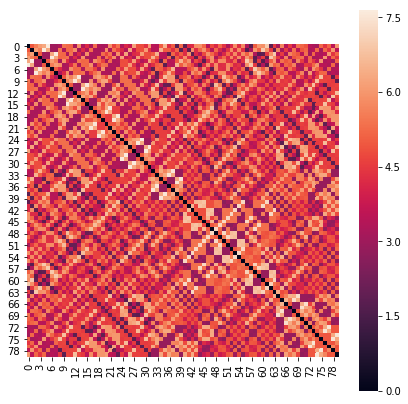

In [23]:
plt.subplots(figsize=(7, 7))
sns.heatmap(dists, square=True);

#### Make crystal graph

In [24]:
cg_factor = get_factor(train.iloc[idx - 1].spacegroup, train.iloc[idx - 1].gamma)

G = get_crytal_graph(pos_red, pos.element, dists, factor=cg_factor)

print "Spacegroup:", train.iloc[idx - 1].spacegroup
print "Gamma:", train.iloc[idx - 1].gamma
print "CG Factor:", cg_factor
print "Node count:", G.number_of_nodes()
print "Edge count:", G.number_of_edges()

for i in range(len(pos.element)):
    sym_i = pos.element[i]
    node_i = '{}_{}'.format(sym_i, i)
    crdn_i = list(G.neighbors(node_i))
    print "{:8s}{:d}   {}".format(node_i, len(crdn_i), crdn_i)

Spacegroup: 33.0
Gamma: 90.0017
CG Factor: 1.4
Node count: 80
Edge count: 176
Ga_0    4   ['O_40', 'O_38', 'O_57', 'O_62']
Al_1    4   ['O_39', 'O_41', 'O_56', 'O_63']
Al_2    4   ['O_42', 'O_60', 'O_59', 'O_36']
Ga_3    4   ['O_43', 'O_37', 'O_58', 'O_61']
Ga_4    4   ['O_45', 'O_60', 'O_58', 'O_34']
Al_5    4   ['O_59', 'O_44', 'O_35', 'O_61']
Al_6    4   ['O_32', 'O_56', 'O_47', 'O_62']
Al_7    4   ['O_33', 'O_57', 'O_46', 'O_63']
Al_8    6   ['O_38', 'O_45', 'O_33', 'O_54', 'O_48', 'O_78']
Ga_9    6   ['O_39', 'O_44', 'O_55', 'O_32', 'O_49', 'O_79']
Ga_10   6   ['O_36', 'O_76', 'O_47', 'O_50', 'O_35', 'O_52']
Al_11   6   ['O_37', 'O_77', 'O_46', 'O_51', 'O_53', 'O_34']
Al_12   6   ['O_40', 'O_74', 'O_34', 'O_51', 'O_36', 'O_52']
Ga_13   6   ['O_75', 'O_41', 'O_53', 'O_37', 'O_50', 'O_35']
Al_14   6   ['O_42', 'O_38', 'O_72', 'O_54', 'O_32', 'O_49']
Ga_15   6   ['O_55', 'O_43', 'O_39', 'O_73', 'O_33', 'O_48']
Ga_16   6   ['O_64', 'O_42', 'O_38', 'O_73', 'O_58', 'O_48']
Al_17   6   [

In [25]:
G.node['Ga_0']

{'atomic_mass': 69.723, 'cn': 4, 'electroneg': 1.81, 'symbol': 'Ga'}

In [26]:
G.edges[('Ga_0', 'O_38', 0)]

{'bond_length': 1.808885609695628, 'symbol': 'Ga-O'}

In [27]:
G['Ga_0']

AdjacencyView({'O_40': {0: {'bond_length': 1.8271305422232218, 'symbol': 'Ga-O'}}, 'O_38': {0: {'bond_length': 1.808885609695628, 'symbol': 'Ga-O'}}, 'O_57': {0: {'bond_length': 1.781654092682299, 'symbol': 'Ga-O'}}, 'O_62': {0: {'bond_length': 1.859283310839619, 'symbol': 'Ga-O'}}})

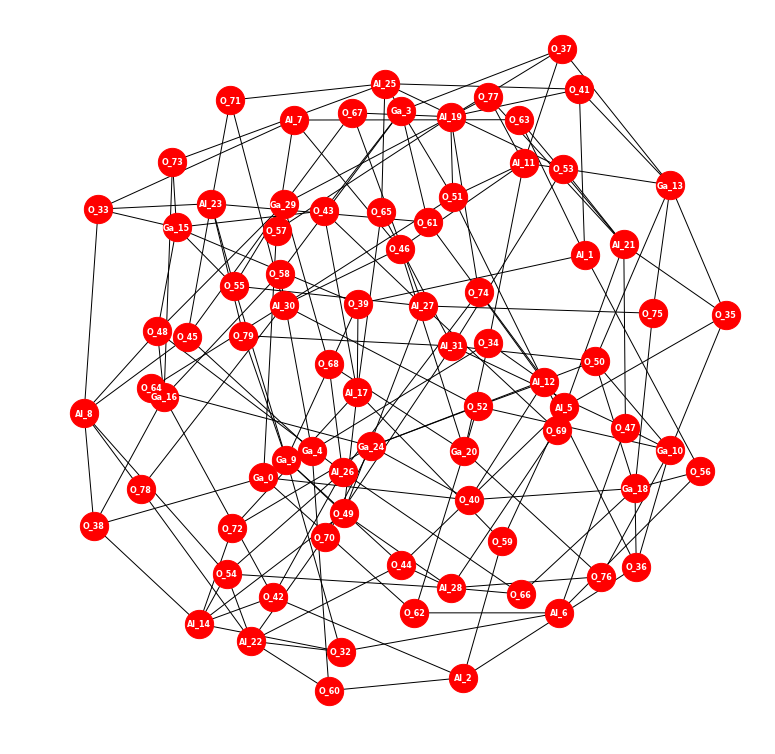

In [28]:
plt.figure(figsize=(10, 10))
nx.draw_spring(G, with_labels=True, node_size=800, font_size=8, font_color='w', font_weight='bold');

#### Get features from CG using Node2Vec

In [29]:
from gensim.models import Word2Vec

In [30]:
def learn_embeddings(walks, dimensions=8, workers=4, window=6, iter_num=200):
    """
    Learn embeddings by optimizing the Skipgram objective using SGD.
    """
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=dimensions, window=window,
                     min_count=0, sg=1, workers=workers, iter=iter_num)
    return model

In [31]:
G_nv = GraphNV(G, 10, 0.6, is_directed=False, weight_key='bond_length')
G_nv.preprocess_transition_probs()
walks = G_nv.simulate_walks(10, 4)

In [32]:
result = learn_embeddings(walks)

In [33]:
word_vectors = result.wv

In [34]:
word_vectors.most_similar('O_36')

[('Ga_10', 0.9259599447250366),
 ('Ga_18', 0.8291816711425781),
 ('O_50', 0.8085079193115234),
 ('Al_12', 0.7867234945297241),
 ('O_52', 0.7796740531921387),
 ('O_76', 0.7710825204849243),
 ('Ga_24', 0.7657938599586487),
 ('O_47', 0.7166074514389038),
 ('O_70', 0.7151227593421936),
 ('O_66', 0.6947793960571289)]

In [35]:
word_vectors['O_36']

array([-0.35378957, -0.4246783 ,  0.11872289,  0.6449348 ,  0.09961691,
       -0.9499697 , -1.0767957 ,  1.7671896 ], dtype=float32)

#### Get features from CG

In [36]:
a_list = []
for n in G.nodes(data=True):
    n[1]['id'] = n[0]
    
    bls = np.array([G.edges[(n[0], m, 0)]['bond_length'] for m in G.neighbors(n[0])])
    n[1]['avg_m-o_bond_length'] = bls.mean()
    n[1]['std_m-o_bond_length'] = bls.std()

    for i in range(6):
        n[1]['v_{}'.format(i)] = word_vectors[n[0]][i]
        
    a_list.append(n[1])

a_df = pd.DataFrame(a_list).set_index('id')

In [37]:
a_df_sum = a_df.groupby('symbol').mean()

In [92]:
a_df_sum.drop(['atomic_mass', 'electroneg'], axis=1)

,avg_m-o_bond_length,cn,std_m-o_bond_length,v_0,v_1,v_2,v_3,v_4,v_5
symbol,,,,,,,,,
Al,1.949009,5.500000,0.109757,0.139215,-0.956003,-0.086952,0.576718,-0.745852,-0.782636
Ga,1.943034,5.500000,0.093294,0.096080,-0.673305,-0.014040,0.739531,-0.821938,-0.918227
O,1.937629,3.666667,0.079646,0.007427,-0.693341,0.008101,0.713217,-0.869658,-0.863694


#### Process all files (test and train)

In [72]:
def process_graph(batch='train'):
    """
    Function to process each .xyz file and return the crystal graph data
    """
    summary_result = []
    
    pbar = tqdm_notebook(os.listdir(os.path.join(DATA_DIR, batch)))
    
    for i in pbar:
        # Load .xyz data
        fname = os.path.join(DATA_DIR, batch, i, 'geometry.xyz')
        pos, latvec, natoms = get_xyz_data(fname)
        
        # Element index
        idx = int(i)
        
        # Calculate reduced coordinates
        pos_R = pos[['x', 'y', 'z']].as_matrix()
        pos_red = convert_to_red(pos_R, lat)
        
        # Get distances between pairs
        dists, Rij_min = get_shortest_distances(pos_red, lat)
        
        # Make CG
        if batch == 'train':
            d = train.iloc[idx - 1]
        elif batch == 'test':
            d = test.iloc[idx - 1]
        cg_factor = get_factor(d.spacegroup, d.gamma)
        G = get_crytal_graph(pos_red, pos.element, dists, factor=cg_factor)
        
        # Perform N2V with bond_lengths as weights
        G_nv = GraphNV(G, 10, 0.6, is_directed=False, weight_key='bond_length')
        G_nv.preprocess_transition_probs()
        walks = G_nv.simulate_walks(10, 4)
        
        result = learn_embeddings(walks)
        word_vectors = result.wv
        
        # Create features
        a_list = []
        for n in G.nodes(data=True):
            n[1]['id'] = n[0]

            bls = np.array([G.edges[(n[0], m, 0)]['bond_length'] for m in G.neighbors(n[0])])
            
            if bls.size > 0:
                n[1]['avg_m-o_bond_length'] = bls.mean()
                n[1]['std_m-o_bond_length'] = bls.std()
            else:
                n[1]['avg_m-o_bond_length'] = 0.0
                n[1]['std_m-o_bond_length'] = 0.0

            for k in range(6):
                n[1]['v_{}'.format(k)] = word_vectors[n[0]][k]

            a_list.append(n[1])
        
        G.clear()

        a_df = pd.DataFrame(a_list).set_index('id')
        a_df_sum = a_df.groupby('symbol').mean()
        
        features = [idx]
        for s in ['Al', 'In', 'Ga', 'O']:
            try:
                features += a_df_sum.drop(['atomic_mass', 'electroneg'], axis=1).loc[s].tolist()
            except KeyError:
                features += [0.0] * 9
        
        summary_result.append(features)
    
    return summary_result

#### Process files

In [73]:
data_train = process_graph(batch='train')

HBox(children=(IntProgress(value=0, max=2400), HTML(value=u'')))

In [74]:
data_test = process_graph(batch='test')

HBox(children=(IntProgress(value=0, max=600), HTML(value=u'')))

In [79]:
np.array(data_train)

array([[ 1.06900000e+03,  1.89209799e+00,  7.80000000e+00, ...,
         9.39420525e-01, -7.35231910e-01, -4.19473680e-02],
       [ 1.85500000e+03,  1.93980178e+00,  5.44000000e+00, ...,
         5.89523919e-01, -9.85791058e-01, -4.05812978e-01],
       [ 7.97000000e+02,  2.00616283e+00,  6.00000000e+00, ...,
         4.77233331e-01, -2.03986704e-03,  3.22256540e-01],
       ...,
       [ 1.47600000e+03,  0.00000000e+00,  0.00000000e+00, ...,
         1.76482436e-01, -1.24055775e-01,  3.93376606e-01],
       [ 1.64400000e+03,  1.96615049e+00,  6.00000000e+00, ...,
         1.15421667e+00, -7.65470547e-01, -3.71078826e-01],
       [ 9.86000000e+02,  1.82994502e+00,  7.15384615e+00, ...,
         9.28527352e-01, -1.06221182e+00, -4.82650069e-01]])

In [85]:
columns = ['id', 'Al_avg_m-o_bond_length', 'Al_avg_cn', 'Al_std_m-o_bond_length',
          'Al_v_0', 'Al_v_1', 'Al_v_2', 'Al_v_3', 'Al_v_4', 'Al_v_5',
           
          'In_avg_m-o_bond_length', 'In_avg_cn', 'In_std_m-o_bond_length',
          'In_v_0', 'In_v_1', 'In_v_2', 'In_v_3', 'In_v_4', 'In_v_5',
           
          'Ga_avg_m-o_bond_length', 'Ga_avg_cn', 'Ga_std_m-o_bond_length',
          'Ga_v_0', 'Ga_v_1', 'Ga_v_2', 'Ga_v_3', 'Ga_v_4', 'Ga_v_5',
           
          'O_avg_m-o_bond_length', 'O_avg_cn', 'O_std_m-o_bond_length',
          'O_v_0', 'O_v_1', 'O_v_2', 'O_v_3', 'O_v_4', 'O_v_5',]

In [89]:
df_train = pd.DataFrame(data_train, columns=columns).sort_values('id')

In [96]:
df_train.head()

,id,Al_avg_m-o_bond_length,Al_avg_cn,Al_std_m-o_bond_length,Al_v_0,Al_v_1,Al_v_2,Al_v_3,Al_v_4,Al_v_5,...,Ga_v_5,O_avg_m-o_bond_length,O_avg_cn,O_std_m-o_bond_length,O_v_0,O_v_1,O_v_2,O_v_3,O_v_4,O_v_5
1067,1,1.949009,5.500000,0.109757,0.263189,-0.884261,-0.036170,0.750605,-0.698487,-0.661276,...,-0.780323,1.937629,3.666667,0.079646,0.127069,-0.853100,0.163005,0.763118,-0.803645,-0.732734
2327,2,1.779137,6.500000,0.649896,0.032869,-0.554428,0.408196,1.157920,-1.205161,0.031592,...,0.283309,1.701934,4.687500,0.470738,-0.361125,-0.369090,-0.136622,1.129468,-1.253904,-0.090321
2219,3,1.883655,5.384615,0.224221,-0.312495,-1.304286,0.072648,0.015579,-0.544383,-0.327499,...,0.235588,1.886253,3.666667,0.206266,-0.161973,-1.233899,0.291731,0.097785,-0.647818,-0.186288
2201,4,2.012969,5.555556,0.141713,-0.371033,-0.838455,0.283264,0.640824,-0.380119,-0.257924,...,0.000000,2.023984,3.611111,0.115877,-0.578469,-0.738934,0.272375,0.632710,-0.161818,-0.045243
2342,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.524899,1.813465,4.958333,0.536679,-0.177194,-0.745338,0.727849,0.925179,-0.707048,-0.737106


In [97]:
df_test = pd.DataFrame(data_test, columns=columns).sort_values('id')

In [98]:
df_test.head()

,id,Al_avg_m-o_bond_length,Al_avg_cn,Al_std_m-o_bond_length,Al_v_0,Al_v_1,Al_v_2,Al_v_3,Al_v_4,Al_v_5,...,Ga_v_5,O_avg_m-o_bond_length,O_avg_cn,O_std_m-o_bond_length,O_v_0,O_v_1,O_v_2,O_v_3,O_v_4,O_v_5
260,1,1.997013,5.666667,0.149430,-0.229542,-0.690060,-0.071598,1.570191,-0.040740,-0.687938,...,-0.722323,2.039899,4.083333,0.259720,0.060481,-0.246262,0.042607,1.223458,-0.488761,-0.947568
578,2,1.946632,5.500000,0.104698,0.240536,-0.306924,0.042656,0.527508,-1.204234,-0.554868,...,-0.607407,1.937739,3.666667,0.077864,0.218927,-0.319189,0.078719,0.532809,-1.276648,-0.548699
543,3,2.016860,6.000000,0.125847,-0.401368,-0.606386,0.310870,0.574860,-0.258066,0.559656,...,0.647948,2.016307,3.611111,0.102570,-0.635103,-0.748690,0.325465,0.460211,-0.197821,0.350782
539,4,1.851650,7.000000,0.391329,-0.253058,-0.822644,0.014520,0.620034,-1.219882,-0.182529,...,0.144882,1.837372,5.125000,0.467283,-0.000689,-0.711740,0.227946,0.971360,-1.139314,-0.059066
583,5,1.841404,6.333333,0.363869,-0.578203,-1.231069,0.219664,0.778618,-0.456018,-0.183017,...,-0.069742,1.942138,5.187500,0.484302,-0.489022,-1.321007,0.086943,0.762741,-0.402170,-0.122682


#### Write out geo test and train data files

In [99]:
df_train.to_csv(os.path.join(DATA_DIR, 'train_geo.csv'), index=False)

In [100]:
df_test.to_csv(os.path.join(DATA_DIR, 'test_geo.csv'), index=False)